# We will use this notebook to create a final table, out of the three "clean" tables we have in DBeaver

In [1]:
# import all libraries that are needed

import requests                 # requests on websites
from bs4 import BeautifulSoup   # html parsing

import pandas as pd             # pandas for data frame
import numpy as np              # numpy for array

import math                     # for math methods
import time                     # for sleep timer

import sql_functions as sf
from sql_functions import *     # functions from file for upload on schema
import sqlalchemy               # for sql connection
import psycopg2                 # for upload on engine

import datetime                 # for date and time
import datetime as dt           # for the csv file with the current date and time
from datetime import date       # for the current date

import re                       # for regular expressions

import matplotlib.pyplot as plt # for plotting
%matplotlib inline
from matplotlib.cbook import _reshape_2D

import seaborn as sns

----
----

# Create the combined table and final cleaning

In [2]:
engine = get_engine()

### drop existing table because it can't be overwritten

In [11]:
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.platforms_complete;
"""
result = engine.execute(sql_text)

### Merging the {platform}_clean tables

In [12]:
sql_text = f"""
CREATE TABLE capstone_jmrs.platforms_complete AS
(SELECT *
 FROM capstone_jmrs.spotahome_clean
 UNION
 SELECT *
 FROM capstone_jmrs.blueground_clean
 UNION
 SELECT *
 FROM capstone_jmrs.rightmove_clean);
 """
result = engine.execute(sql_text)


### delete very high price_sqm (which mostly result from defective size values in offers; e.g. 30 sqft instead of actually 30sqm)

In [13]:
sql_text = f"""
DELETE
FROM capstone_jmrs.platforms_complete
WHERE price_sqm > (
                    SELECT MAX(price_sqm)
                    FROM capstone_jmrs.platforms_complete
                    WHERE platform = 'Spotahome'
                );
"""
result = engine.execute(sql_text)

-----
----

# We will plot some graphs with the final data

In [14]:
# Schema / Database configure:
schema = 'capstone_jmrs'

# Table name:
table_name = 'platforms_complete'


In [15]:
# Select the combined Data form DBeaver Database

sql = f"""
SELECT *
FROM {schema}.{table_name} as platforms_complete
""" 
# Take the SQL-Command and import all Data into the variable df
platforms_complete = get_dataframe(sql) 
display(platforms_complete.head(3))

,platform_id,platform,neighbourhood,furniture,property_type,size_sqm,bedrooms,bathrooms,price,price_sqm,price_bedroom,available_from,available_today,let_type,detailed_furniture,scraping_date
0,127896770,Rightmove,Lambeth,furnished,Flat,NaN,2.0,2.0,3878.0,NaN,1939.0,2022-10-12,available,Long term,furnished,2022-10-12
1,127460438,Rightmove,Lambeth,furnished,Flat,NaN,1.0,1.0,1560.0,NaN,1560.0,2022-10-12,available,Long term,furnished,2022-10-12
2,85887825,Rightmove,City of Westminster,unfurnished,Flat,NaN,1.0,1.0,2150.0,NaN,2150.0,2022-12-08,occupied,Long term,part furnished,2022-10-12


In [16]:
plot_platforms_complete = platforms_complete

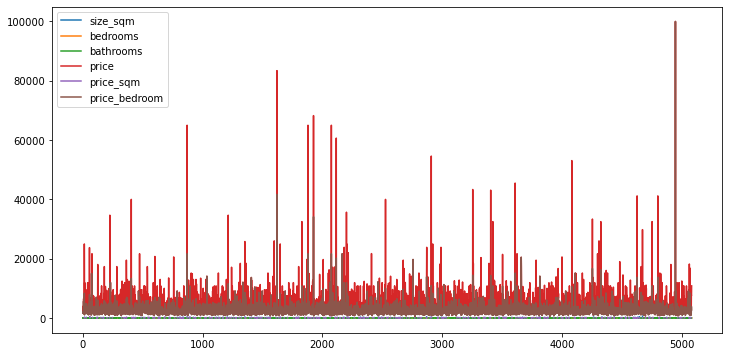

In [17]:
plot_platforms_complete.plot(figsize=(12,6));

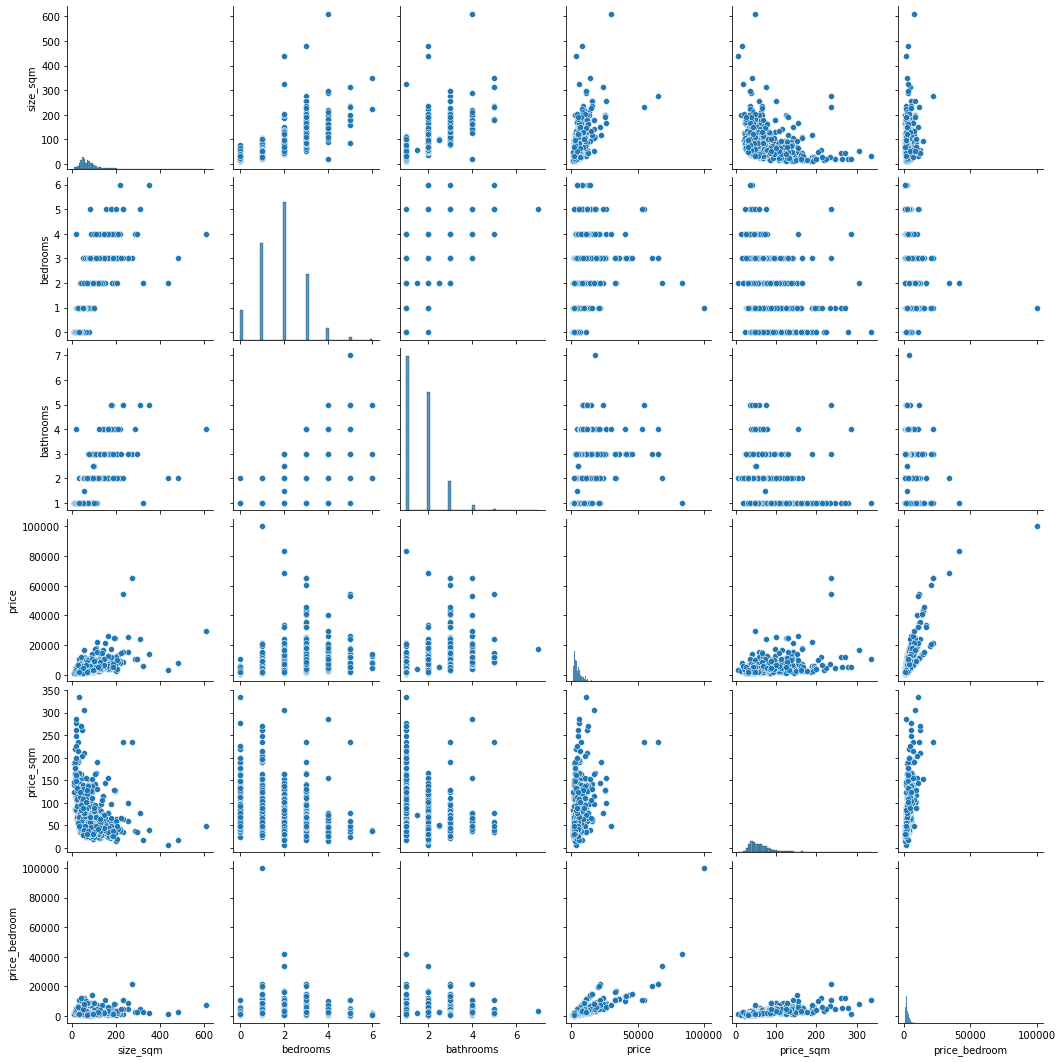

In [18]:
# Create the default pairplot
sns.pairplot(plot_platforms_complete);

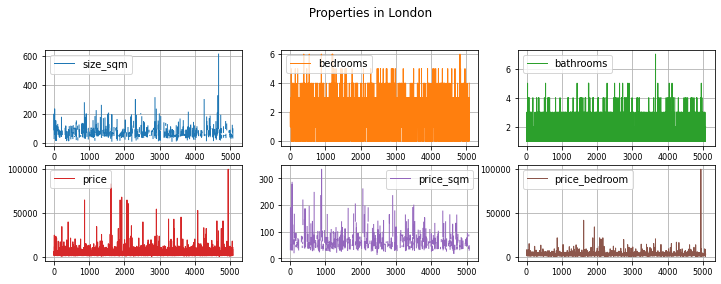

In [19]:
plot_platforms_complete.plot(figsize=(12,6), subplots=True, layout=(3,3), sharex=False, sharey=False, legend=True, fontsize=8, title=' Properties in London', linestyle='solid', linewidth=1, grid=True);

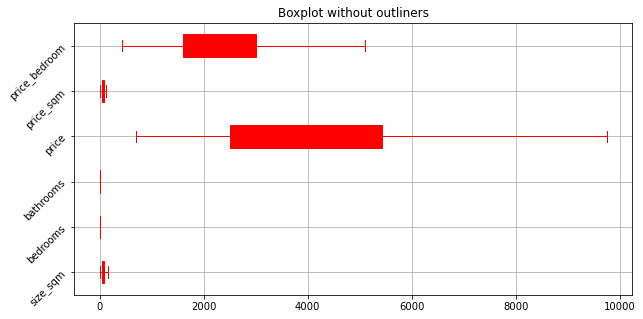

In [20]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# without outliners
plot_platforms_complete.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot without outliners', color='red', vert=False, patch_artist=True, showfliers=False);

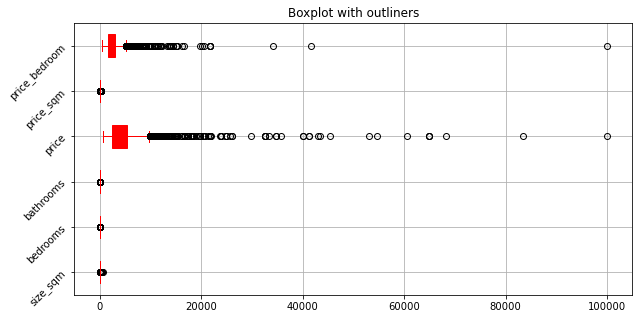

In [21]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_platforms_complete.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot with outliners', color='red', vert=False, patch_artist=True, showfliers=True);

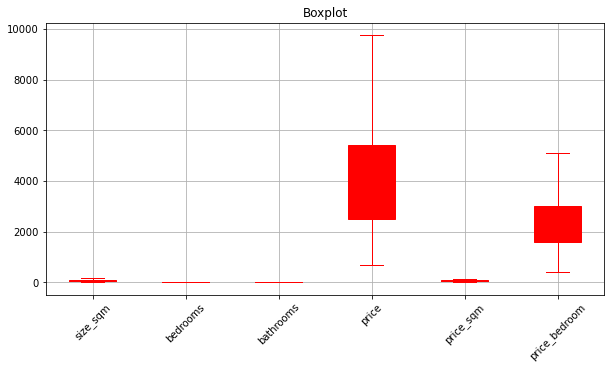

In [22]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_platforms_complete.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=False, subplots=False, sharex=False, sharey=False);

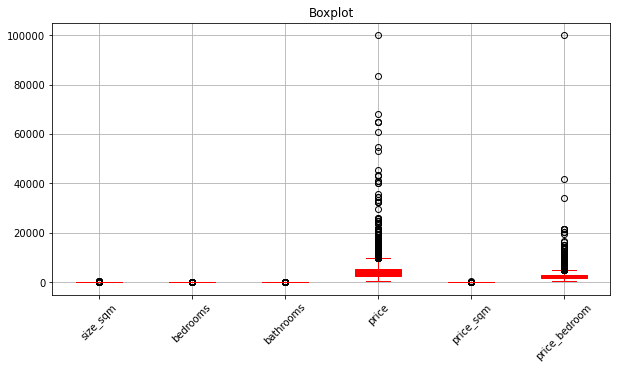

In [23]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_platforms_complete.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=False, sharex=False, sharey=False);

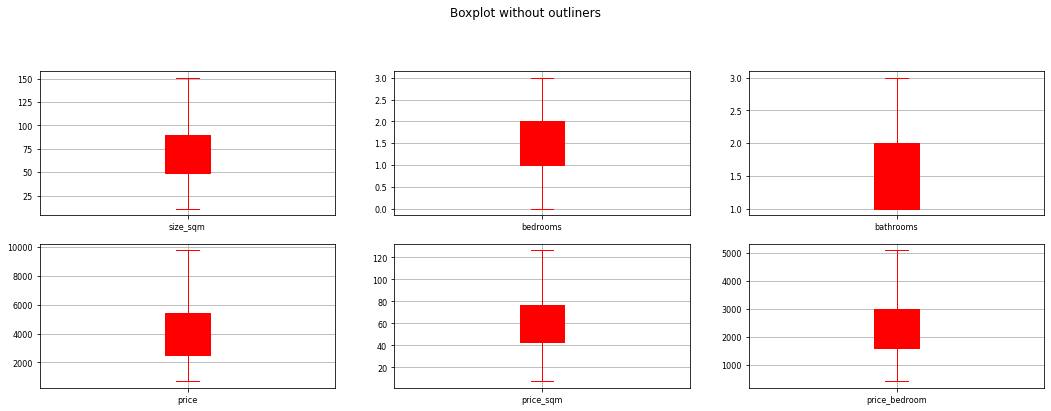

In [24]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# without outliners
plot_platforms_complete.plot(kind='box', figsize=(18, 9), rot=0, fontsize=8, grid=True, title='Boxplot without outliners', color='red', vert=True, patch_artist=True, showfliers=False, subplots=True, layout=(3, 3), legend=True);

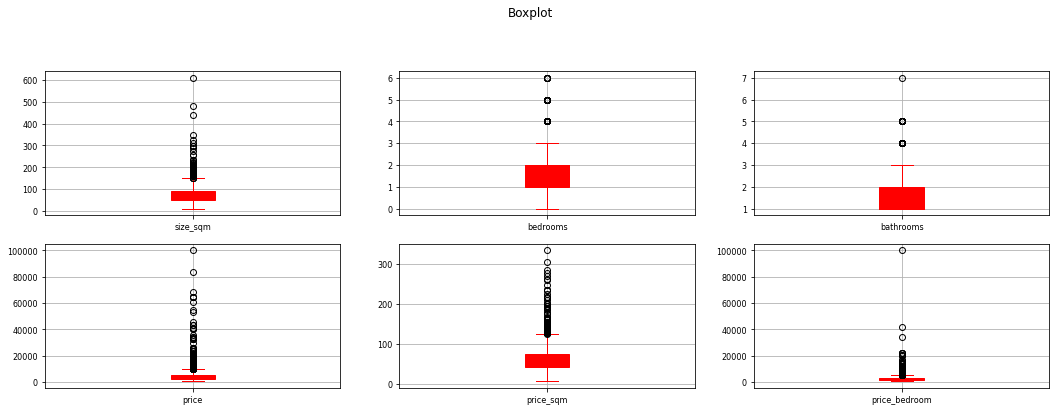

In [25]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_platforms_complete.plot(kind='box', figsize=(18, 9), rot=0, fontsize=8, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=True, layout=(3, 3), legend=True);

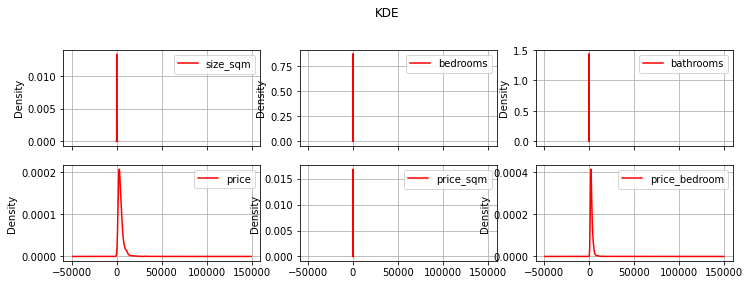

In [26]:
plot_platforms_complete.plot(kind='kde', figsize=(12, 6), fontsize=10, grid=True, title='KDE', color='red', subplots=True, layout=(3, 3), legend=True);

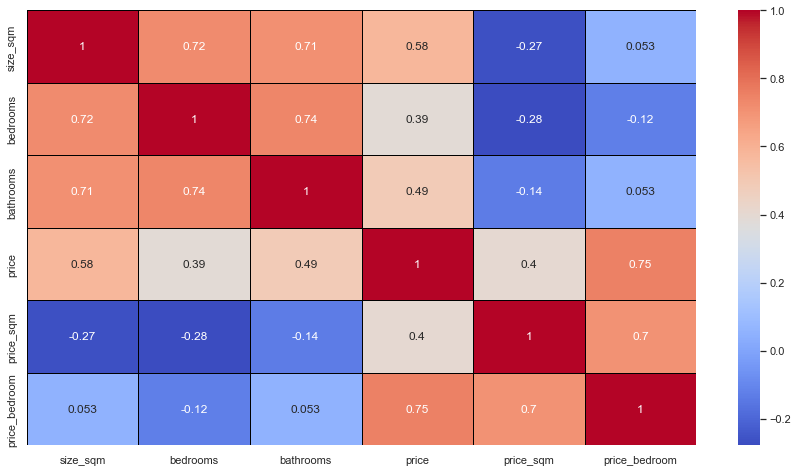

In [27]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(plot_platforms_complete.corr(), annot=True, cmap='coolwarm', linewidths=1, linecolor='black');

In [28]:
sql_text = f"""
SELECT *
FROM capstone_jmrs.platforms_complete AS pc 
WHERE pc.furniture = 'unfurnished'
AND pc.platform = 'Rightmove'
AND pc.neighbourhood = 'City of Westminster' ;
"""
rightmove_unfurniture = get_dataframe(sql_text) 

In [29]:
sql_text = f"""
SELECT *
FROM capstone_jmrs.platforms_complete AS pc 
WHERE pc.furniture = 'furnished'
AND (pc.platform = 'Blueground' or pc.platform = 'Spotahome')
AND pc.neighbourhood = 'City of Westminster' ;
"""
bs_furniture = get_dataframe(sql_text) 

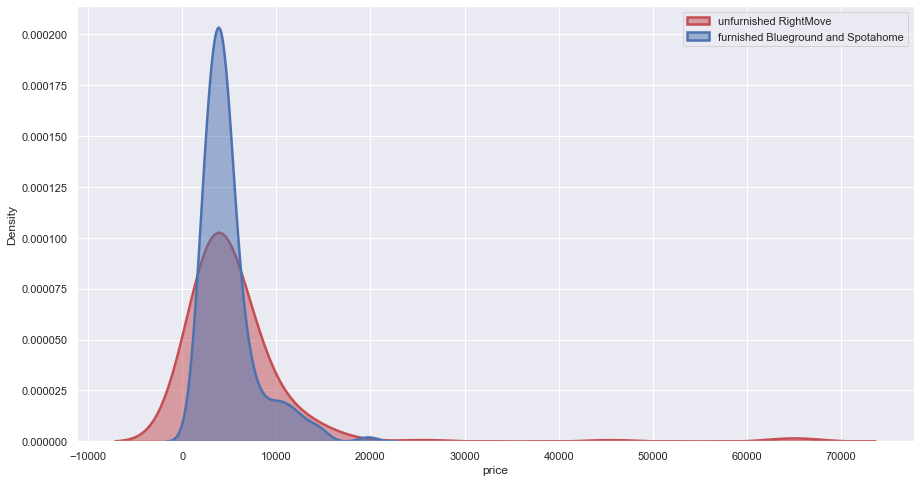

In [30]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
 
# plotting both distibutions on the same figure
fig = sns.kdeplot(rightmove_unfurniture.price, shade=True, color="r", label='price', alpha=0.5, linewidth=2.5, linestyle='solid')
fig = sns.kdeplot(bs_furniture.price, shade=True, color="b", label='price_bedroom', alpha=0.5, linewidth=2.5, linestyle='solid')
fig.legend(labels=['unfurnished RightMove','furnished Blueground and Spotahome'])
plt.show()

----
----

## Create a .csv file from the final table

In [3]:
schema = 'capstone_jmrs'
table_name = 'platforms_complete'

sql = f"""
SELECT *
FROM {schema}.{table_name} as platforms_complete
""" 
platforms_complete = get_dataframe(sql) 
display(platforms_complete.head(3))

,platform_id,platform,neighbourhood,furniture,property_type,size_sqm,bedrooms,bathrooms,price,price_sqm,price_bedroom,available_from,available_today,let_type,detailed_furniture,scraping_date
0,127896770,Rightmove,Lambeth,furnished,Flat,NaN,2.0,2.0,3878.0,NaN,1939.0,2022-10-12,available,Long term,furnished,2022-10-12
1,127460438,Rightmove,Lambeth,furnished,Flat,NaN,1.0,1.0,1560.0,NaN,1560.0,2022-10-12,available,Long term,furnished,2022-10-12
2,85887825,Rightmove,City of Westminster,unfurnished,Flat,NaN,1.0,1.0,2150.0,NaN,2150.0,2022-12-08,occupied,Long term,part furnished,2022-10-12


In [4]:
platforms_complete.to_csv('data/platforms_complete.csv', sep='\t')
print("The csv-file was created successfully.")

The csv-file was created successfully.
